# Entreno en 2500 pruebo en 20mil

In [1]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

## Funcion de ayuda

In [2]:
def run_test(clf, tile, X_columns, y_column):
    X_test = tile[X_columns].values
    y_test = tile[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    print metrics.classification_report(y_test, predictions)
    
    return Container({
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})

## Train 2.5K

In [3]:
sample = pd.read_pickle("data/ogle3_only/scaled/s2_5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de 20k con media y desvio del de 2.5k

In [4]:
skl = pickle.load(open("data/ogle3_only/scalers/scaler_2_5k.pkl"))

In [5]:
sample = pd.read_pickle("data/ogle3_only/nonull/s20k.pkl.bz2")

sample[X_columns] = skl.transform(sample[X_columns])

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [6]:
clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy")
clf_small.fit(train.b278[X_columns].values, train.b278.cls.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [7]:
result_small = run_test(clf_small, test.b261, X_columns, "cls")

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19972
          1       0.73      0.89      0.80       221

avg / total       1.00      1.00      1.00     20193



## Train 5K

In [8]:
sample = pd.read_pickle("data/ogle3_only/scaled/s5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de 20k con media y desvio del de 5k

In [9]:
skl = pickle.load(open("data/ogle3_only/scalers/scaler_5k.pkl"))

In [10]:
sample = pd.read_pickle("data/ogle3_only/nonull/s20k.pkl.bz2")

sample[X_columns] = skl.transform(sample[X_columns])

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [11]:
clf_med = RandomForestClassifier(n_estimators=500, criterion="entropy")
clf_med.fit(train.b278[X_columns].values, train.b278.cls.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
result_med = run_test(clf_med, test.b261, X_columns, "cls")

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19972
          1       0.86      0.83      0.85       221

avg / total       1.00      1.00      1.00     20193



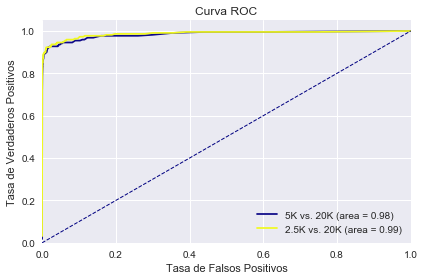

In [13]:
roc({"5K vs. 20K": result_med, "2.5K vs. 20K": result_small})

In [14]:
test.b278.AmplitudeH

81116     2.414786
81117     0.367517
81118    -1.281542
81119    -0.944235
81120    -0.232141
81121     0.597073
81122    -1.051986
81123    -1.319021
81124     0.163727
81125    -0.602242
81126     0.627525
81127     0.732933
81128     3.407969
81129     0.119221
81130    -1.084780
81131     0.278505
81132    -1.108204
81133    -0.988741
81134    -0.606927
81135    -1.066040
81136    -0.822429
81137    -0.349262
81138    -0.855223
81139    -1.173791
81140     0.601758
81141    -0.517915
81142    -1.145682
81143    -0.508546
81144    -0.171238
81145     0.119221
            ...   
101509    0.142645
101510    0.095797
101511   -0.695939
101512    0.156700
101513   -0.529628
101514   -0.100966
101515    0.472925
101516    0.175439
101517   -0.588188
101518   -0.663145
101519   -0.953604
101520   -0.396110
101521   -0.110336
101522    0.196521
101523   -0.471067
101524   -0.023666
101525    0.166069
101526    0.032552
101527    0.128591
101528   -0.850538
101529    0.039579
101530    1.